In [1]:
from matplotlib.finance import *
import matplotlib.pyplot as plt
from matplotlib import ticker, gridspec
from matplotlib.dates import DateFormatter, WeekdayLocator,MONDAY
from datetime import timedelta, datetime as dt
import pandas as pd
import numpy as np
import requests
import talib

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def get_data_yahoo(symbol, start, end):
    url = "https://query1.finance.yahoo.com/v7/finance/chart/{}?period1={:.0f}&period2={:.0f}"\
          "&interval=1d&indicators=quote&includeTimestamps=true&"\
          "events=div%7Csplit%7Cearn".format(symbol, start.timestamp(), end.timestamp())
            
    page = requests.get(url)
    result = page.json()['chart']['result']
    if not result:
        print(symbol, page.json())
        return
    
    data = result[0]
    quote = data['indicators']['quote'][0]
    if 'timestamp' not in data:
        print("Unexpected response for {}".format(symbol))
        return
    
    result = pd.DataFrame(
        index=pd.Index(data=[dt.fromtimestamp(t).date() for t in data['timestamp']], name="Date"),
        data=dict(
            Open=quote["open"],
            High=quote["high"],
            Low=quote["low"],
            Close=quote["close"],
            Volume=quote["volume"],
        )
    )   
    return result

In [3]:
def get_data(key, start, end):
    df = get_data_yahoo(key, start, end)
    
    # Double Smoothed PC
    # PC = Current Price less Prior Price
    # First Smoothing = 25-period EMA of PC
    # Second Smoothing = 13-period EMA of 25-period EMA of PC
    # Double Smoothed Absolute PC
    # Absolute Price Change |PC| = Absolute Value of Current Price less Prior Price
    # First Smoothing = 25-period EMA of |PC|
    # Second Smoothing = 13-period EMA of 25-period EMA of |PC|
    # TSI = 100 x (Double Smoothed PC / Double Smoothed Absolute PC)
    mom = talib.MOM(df.Close.values, 1)
    df['MOM'] = pd.Series(mom, index=df.index.values)
    fs_mom = talib.EMA(mom, 25)
    ds_mom = talib.EMA(fs_mom, 13)
    
    abs_mom = np.abs(mom)
    fs_abs_mom = talib.EMA(abs_mom, 25)
    ds_abs_mom = talib.EMA(fs_abs_mom, 13)
    tsi = ds_mom / ds_abs_mom * 100
    df['TSI'] = pd.Series(tsi, index=df.index.values)
    df['TSI_RED'] = pd.Series(talib.EMA(tsi, 13), index=df.index.values)
    
    
    # AO = SMA(High+Low)/2, 5 Periods) - SMA(High+Low/2, 34 Periods)
    df['AO'] = pd.Series(
        talib.SMA((df.High + df.Low).values / 2, 5) - talib.SMA((df.High + df.Low).values / 2, 34), 
        index=df.index.values
    )
    
    # Vortex Indicator
    ss = df.shift(1)
    period = 14
    tr = df.High.combine(ss.Close, max) - df.Low.combine(ss.Close, min)
    trp = tr.rolling(window=period).sum()
    vmp = np.abs(df.High - ss.Low)
    vmm = np.abs(df.Low - ss.High)    
    df['VI_PLUS'] = vmp.rolling(window=period).sum() / trp
    df['VI_MINUS'] = vmm.rolling(window=period).sum() / trp    
    
    # AROON
    down, up = talib.AROON(df['High'].values, df['Low'].values)
    df['AROON_DOWN'] = pd.Series(down, index=df.index.values)
    df['AROON_UP'] = pd.Series(up, index=df.index.values)
    
    # BBANDS
    upper, middle, lower = talib.BBANDS(df['Close'].values)
    df['BB_UPPER'] = pd.Series(upper, index=df.index.values)
    df['BB_MIDDLE'] = pd.Series(middle, index=df.index.values)
    df['BB_LOWER'] = pd.Series(lower, index=df.index.values)

    
    # RVGI
    # RVI = (Close – Open) / (High – Low) for each period
    rvi = ((df.Close - df.Open) / (df.High - df.Low)).values
    green = talib.SMA(rvi, 10)
    df['RVGI_GREEN'] = pd.Series(green, index=df.index.values)
    df['RVGI_RED'] = talib.WMA(green, 4)
    
    
    # Price and AO Regression directions
    def regression_direction(values):
        values = np.vstack([values, np.ones(len(values))]).T
        return np.linalg.lstsq(values, range(len(values)), rcond=None)[0][0]
    
    # Price regression
    df['PR'] = df.Close.rolling(window=45).apply(regression_direction)
    df['AOR'] = df.AO.rolling(window=45).apply(regression_direction)    
    
    return df

frame = get_data('BAC', dt(2016, 1, 1), dt(2017, 1, 1))
frame[-2:]

,Close,High,Low,Open,Volume,MOM,TSI,TSI_RED,AO,VI_PLUS,VI_MINUS,AROON_DOWN,AROON_UP,BB_UPPER,BB_MIDDLE,BB_LOWER,RVGI_GREEN,RVGI_RED,PR,AOR
Date,,,,,,,,,,,,,,,,,,,,
2016-12-29,22.0,22.389999,21.770000,22.33,78979400,-0.33,33.927381,45.278920,1.006029,0.828239,1.085881,100.000000,35.714286,22.878447,22.416,21.953554,-0.217090,-0.154272,5.287748,7.692667
2016-12-30,22.1,22.260000,21.950001,22.02,72605900,0.10,30.917671,43.227313,0.804530,0.839470,1.095729,92.857143,28.571429,22.828464,22.328,21.827536,-0.235351,-0.194665,5.329463,6.340201


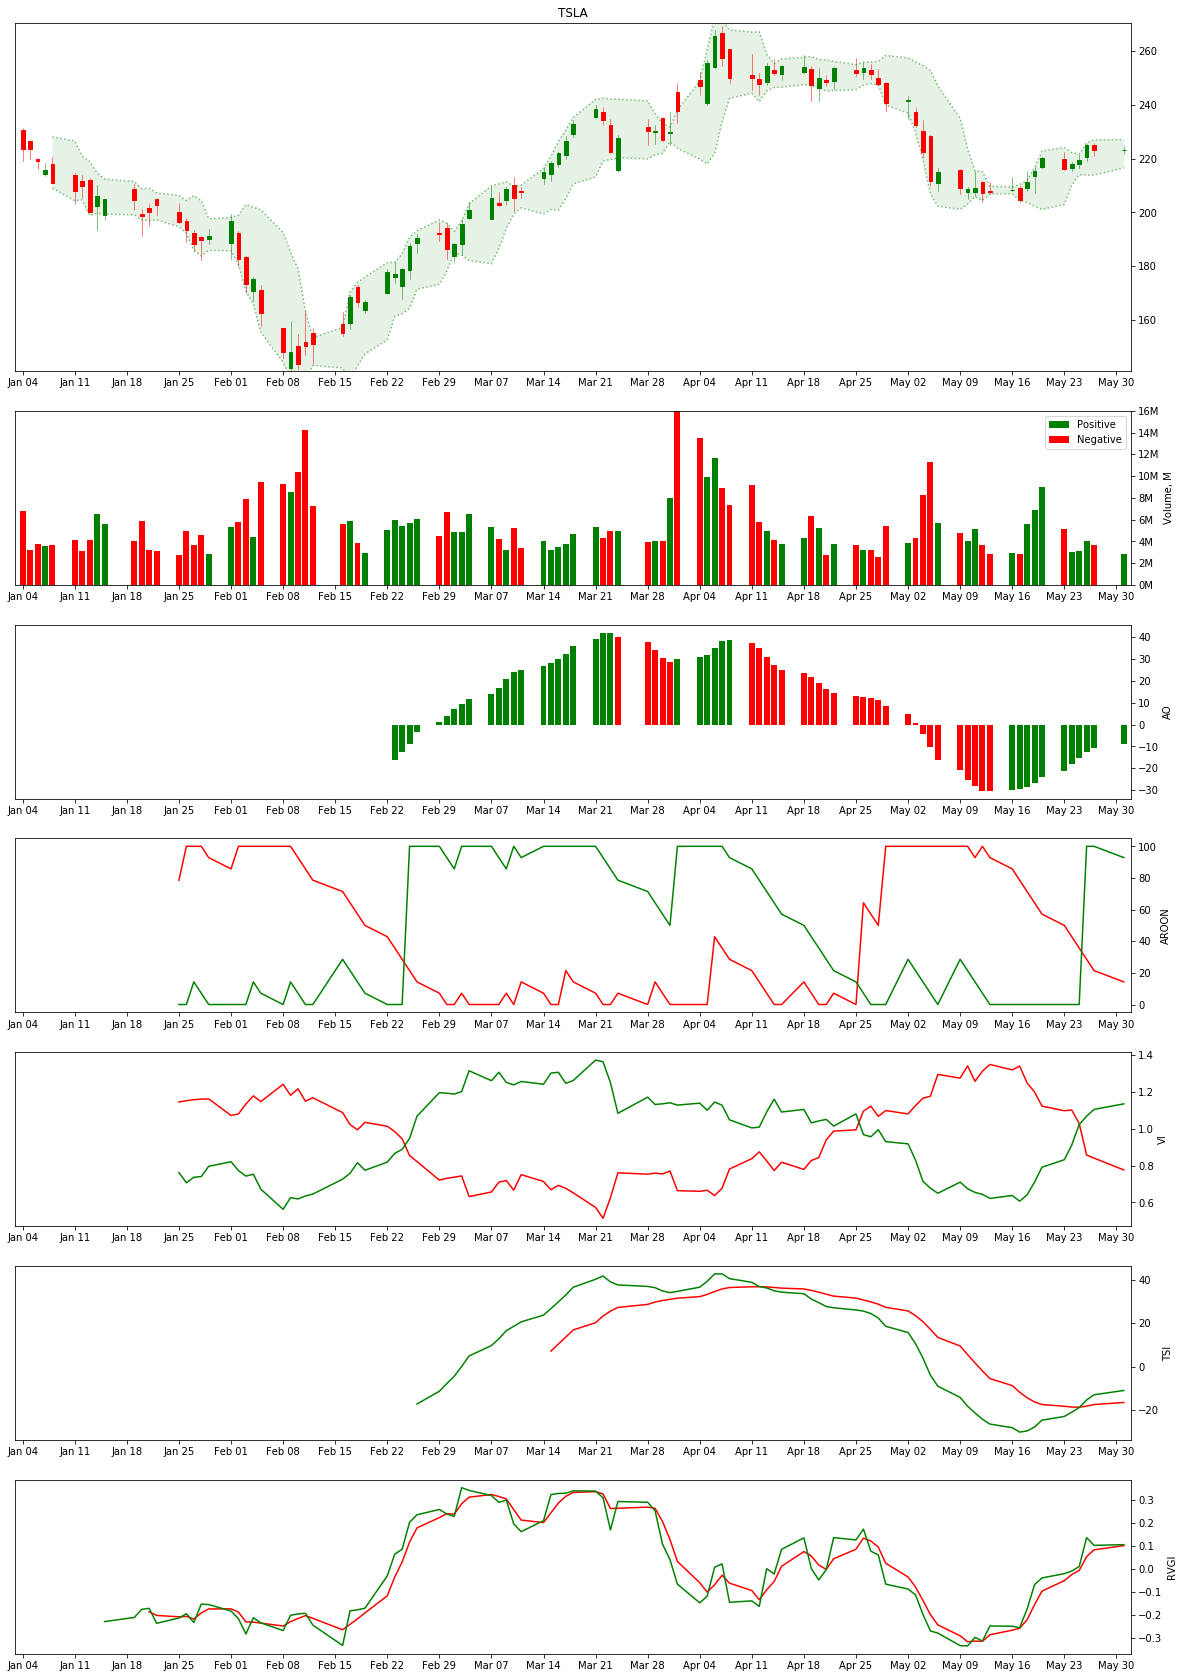

In [4]:
def plot_data(title, initial_df, instance=None, show=True):   
    
    if instance:       
        instance_index = initial_df.index.get_loc(instance)
        df = initial_df.iloc[max(instance_index - 50, 0): instance_index + 30] 
    else:
        df = initial_df.copy()            
    df.index = [date2num(date) for date in df.index]
        
    fig = plt.figure(figsize=(20, 30)) 
    gs = gridspec.GridSpec(7, 1, height_ratios=[2, 1, 1, 1, 1, 1, 1]) 
    
    # add ticks 
    weekFormatter = DateFormatter('%b %d')
    mondays = WeekdayLocator(MONDAY)   
    x_min, x_max = df.index.min() -1, df.index.max() + 1
    

    # Plot the candlestick
    ax1 = plt.subplot(gs[0])
    candlestick_ochl(
        ax1, 
        ((r.Index, r.Open, r.Close, r.High, r.Low) 
         for r in df.itertuples()), 
        width=.5,  
        colorup='g',  
        colordown='r',
    )
    ax1.xaxis.set_major_locator(mondays)
    ax1.xaxis.set_major_formatter(weekFormatter)
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(df.Low.min(), df.High.max() + 1)
    
    # BB_UPPER, BB_MIDDLE, BB_LOWER
    ax1.plot(df.index, df.BB_UPPER, color='green', linestyle="dotted", label="UPPER", alpha=.5) 
    ax1.plot(df.index, df.BB_LOWER, color='green', linestyle="dotted", label="LOWER", alpha=.5)
    ax1.fill_between(df.index, df.BB_UPPER, df.BB_LOWER, facecolor='green', interpolate=True, alpha=.1)
    
    plt.title(title)
    
    # Plot the volume overlay
    ax2 = plt.subplot(gs[1])  
    pos_volumes = df[df.Close >= df.Open]
    neg_volumes = df[df.Close < df.Open]
    ax2.bar(pos_volumes.index, pos_volumes['Volume'].tolist(), color='green', align='center', label="Positive")
    ax2.bar(neg_volumes.index, neg_volumes['Volume'].tolist(), color='red', align='center', label="Negative") 
    ax2.legend(fancybox=True, loc='best')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x,p: "%dM" % (x / 1000000)))
    ax2.set_ylabel('Volume, M')
    ax2.xaxis.set_major_locator(mondays)  
    ax2.xaxis.set_major_formatter(weekFormatter)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, df.Volume.max())
    
    
    # AO   
    positive = df[df.AO >= df.AO.shift(1)].AO
    negative = df[df.AO < df.AO.shift(1)].AO    
    ax3 = plt.subplot(gs[2])
    ax3.bar(positive.index, positive, color='green', align='center', label="Positive") 
    ax3.bar(negative.index, negative, color='red', align='center', label="Negative")
    ax3.set_ylabel('AO')
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    ax3.xaxis.set_major_locator(mondays) 
    ax3.xaxis.set_major_formatter(weekFormatter) 
    ax3.set_xlim(x_min, x_max)
    
    # AROON  
    ax4 = plt.subplot(gs[3])
    ax4.plot(df.index, df.AROON_DOWN, color='red', label="DOWN") 
    ax4.plot(df.index, df.AROON_UP, color='green', label="UP") 
    ax4.set_ylabel('AROON')
    ax4.yaxis.set_label_position("right")
    ax4.yaxis.tick_right()
    ax4.xaxis.set_major_locator(mondays) 
    ax4.xaxis.set_major_formatter(weekFormatter) 
    ax4.set_xlim(x_min, x_max)
    
    # VI  
    ax5 = plt.subplot(gs[4])
    ax5.plot(df.index, df.VI_MINUS, color='red', label="VI-") 
    ax5.plot(df.index, df.VI_PLUS, color='green', label="VI+") 
    ax5.set_ylabel('VI')
    ax5.yaxis.set_label_position("right")
    ax5.yaxis.tick_right()
    ax5.xaxis.set_major_locator(mondays) 
    ax5.xaxis.set_major_formatter(weekFormatter) 
    ax5.set_xlim(x_min, x_max)
    
    # TSI
    ax6 = plt.subplot(gs[5])
    ax6.plot(df.index, df.TSI_RED, color='red', label="RED") 
    ax6.plot(df.index, df.TSI, color='green', label="GREEN") 
    ax6.set_ylabel('TSI')
    ax6.yaxis.set_label_position("right")
    ax6.yaxis.tick_right()
    ax6.xaxis.set_major_locator(mondays) 
    ax6.xaxis.set_major_formatter(weekFormatter) 
    ax6.set_xlim(x_min, x_max)
    
    # RVGI
    ax7 = plt.subplot(gs[6])
    ax7.plot(df.index, df.RVGI_RED, color='red', label="RED") 
    ax7.plot(df.index, df.RVGI_GREEN, color='green', label="GREEN") 
    ax7.set_ylabel('RVGI')
    ax7.yaxis.set_label_position("right")
    ax7.yaxis.tick_right()
    ax7.xaxis.set_major_locator(mondays) 
    ax7.xaxis.set_major_formatter(weekFormatter) 
    ax7.set_xlim(x_min, x_max)
    
    # highlight instance days, and show only -90 + 50 days
    if instance:  
        instance = date2num(instance)
        for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7):
            ax.axvspan(instance - .5, instance + .5, color='yellow', alpha=0.3)
    
    if show:
        plt.show()

plot_data("TSLA", get_data('TSLA', dt(2016, 1, 1), dt(2016, 6, 1)))

In [5]:
def get_pattern_instances(df):
    df['max19daysClose'] = df.Close.rolling(window=19).max()
    df['average30daysAO'] = df.AO.rolling(window=30).mean()
    
    # Did the ‘Close’ price make a new 20 trading days high?    
    df = df[df.Close > df.max19daysClose.shift(1)] 
    
    # Is Awesome Oscillator (AO) above zero AND the average of the AO’s last 30 trading days was below zero?
    df = df[(df.AO > 0) & (df.average30daysAO < 0)] 
    
    # Is the 45 trading days price regression line slope negative AND is the AO regression line slope positive?
    df = df[(df.PR < 0) & (df.AOR > 0)] 
    
    #  Is AROON in the buy zone (green line above red line)?
    df = df[df.AROON_UP > df.AROON_DOWN]
    
    # Is Vortex Indicator (VI) in the buy zone (green line above red line)?
    df = df[df.VI_PLUS > df.VI_MINUS]
    
    # Is TSI in the buy mode (green line above red line)?
    df = df[df.TSI > df.TSI_RED]
    
    # Did the price pierce the upper band of the Bollinger Bands?
    df = df[df.High > df.BB_UPPER]
    
    # Is the weekly RVGI in the buy mode – green line above or equal to red line?
    df = df[df.RVGI_GREEN > df.RVGI_RED]
    
    return df.index.tolist()

get_pattern_instances(get_data('TSLA', dt(2011, 1, 1), dt(2017, 1, 1)))

[datetime.date(2011, 9, 23),
 datetime.date(2016, 3, 14),
 datetime.date(2016, 12, 14),
 datetime.date(2016, 12, 19)]

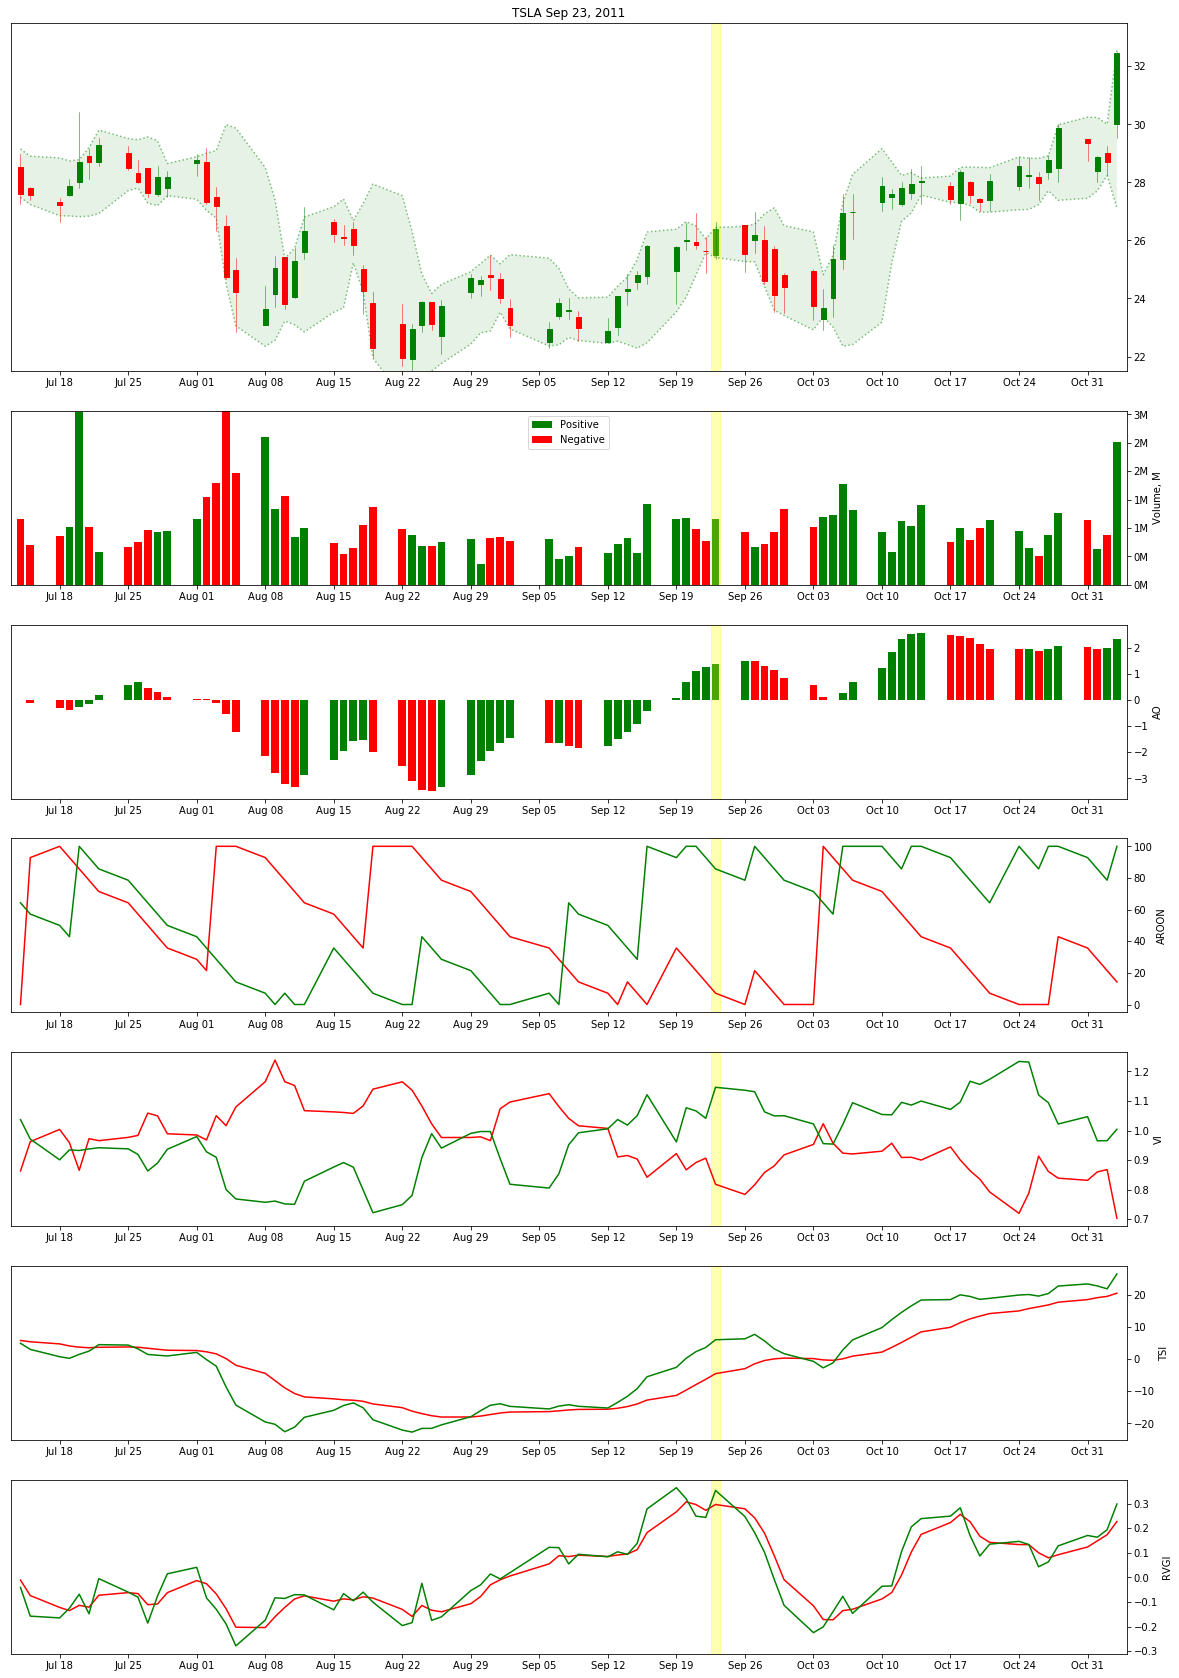

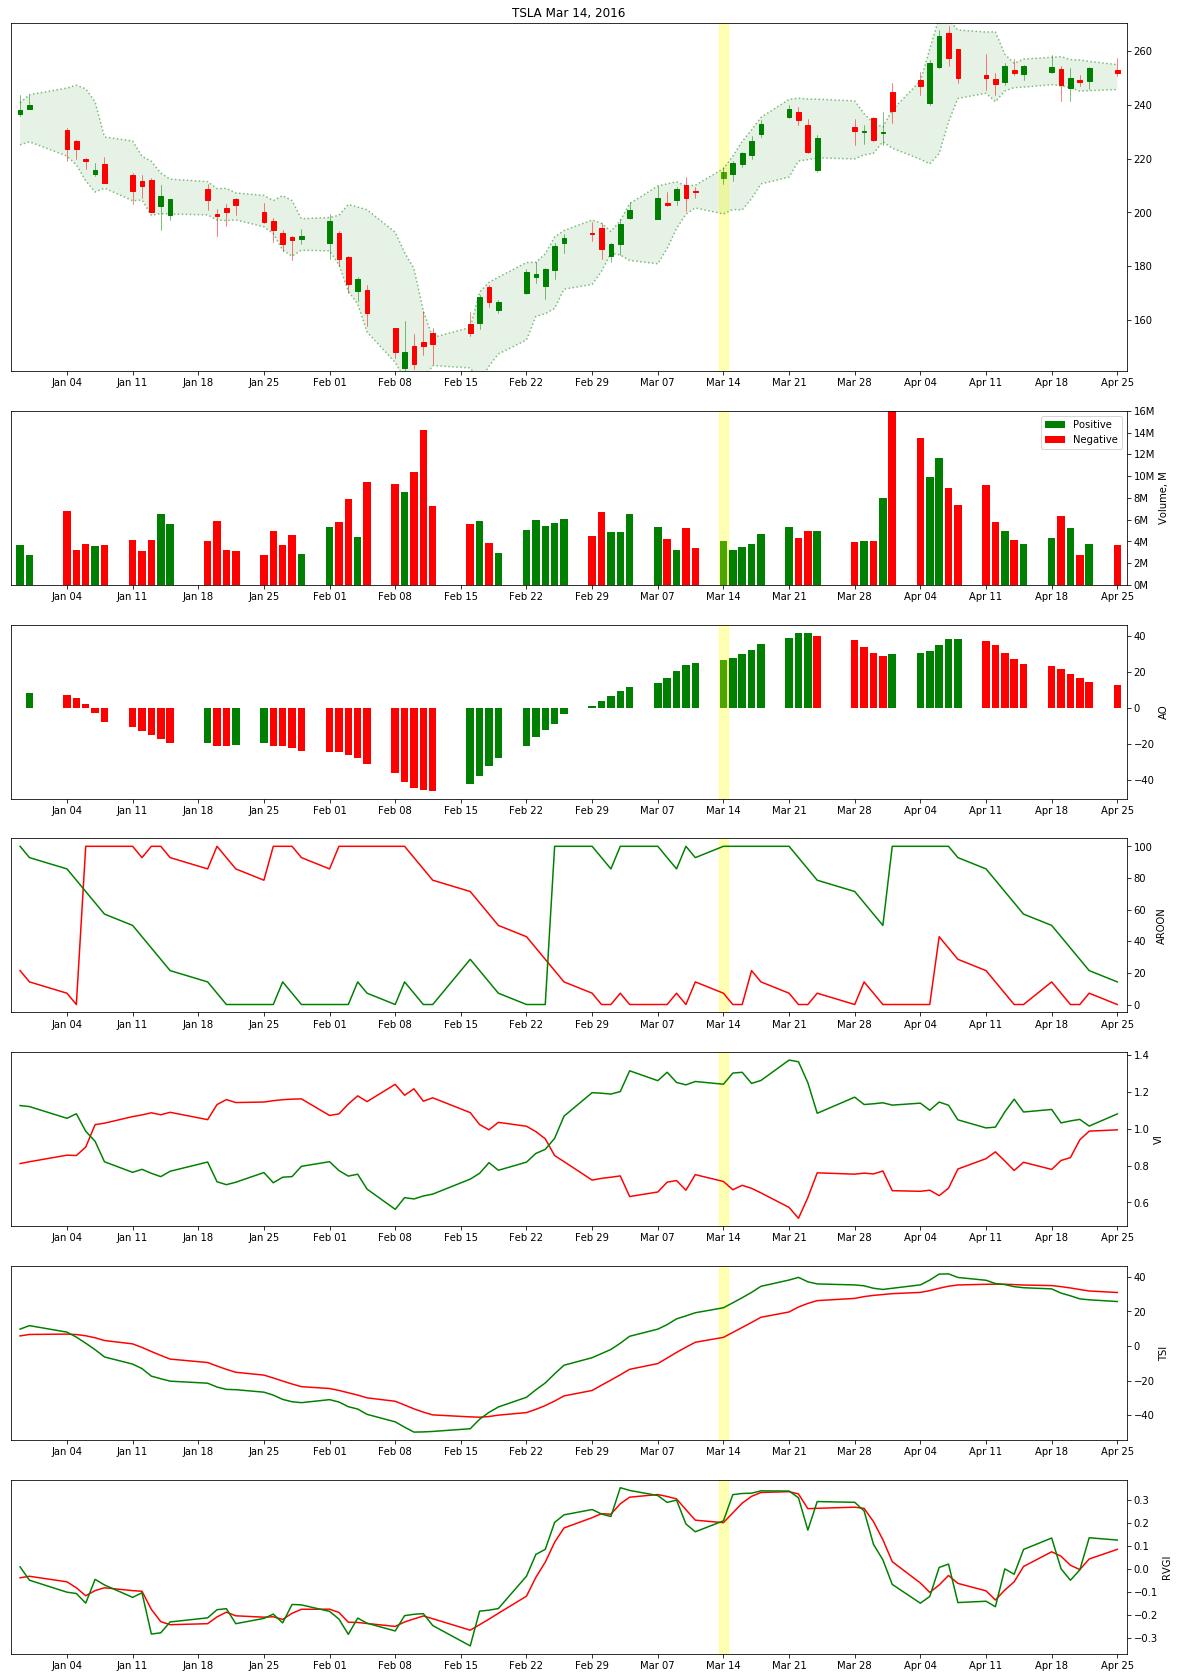

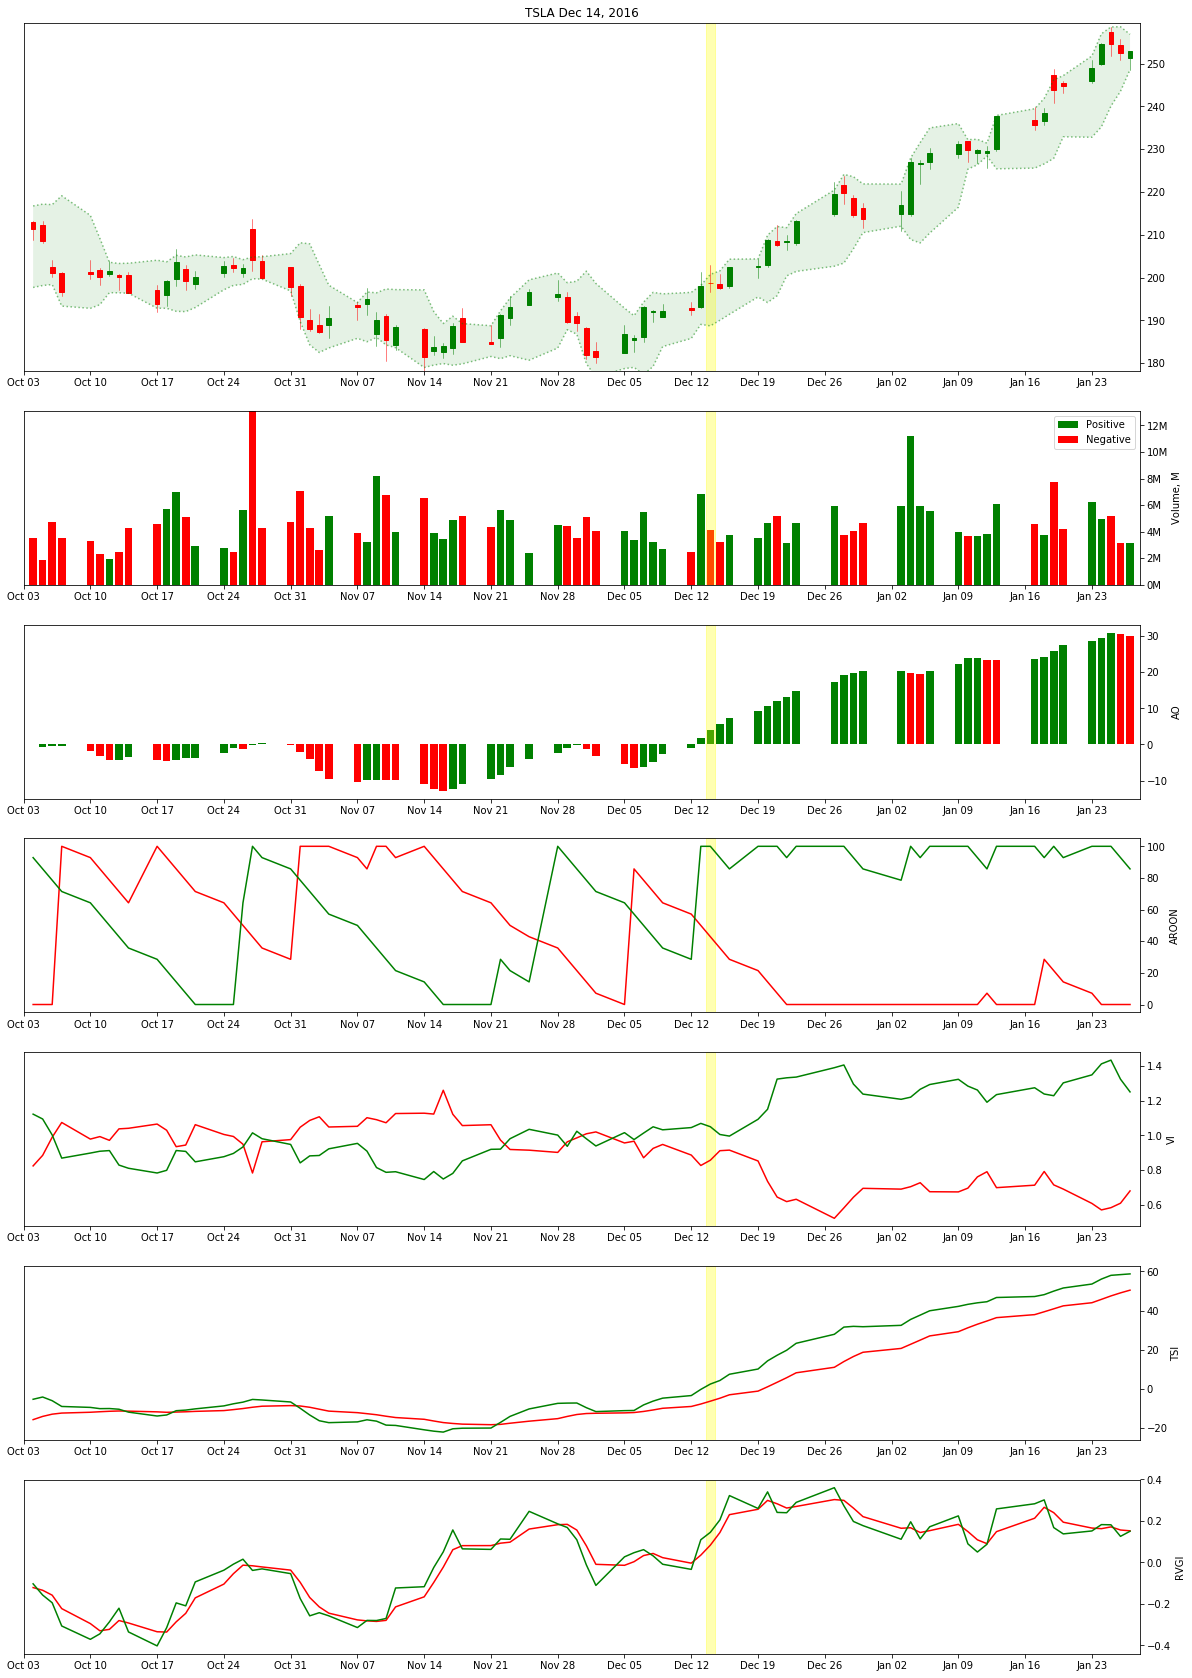

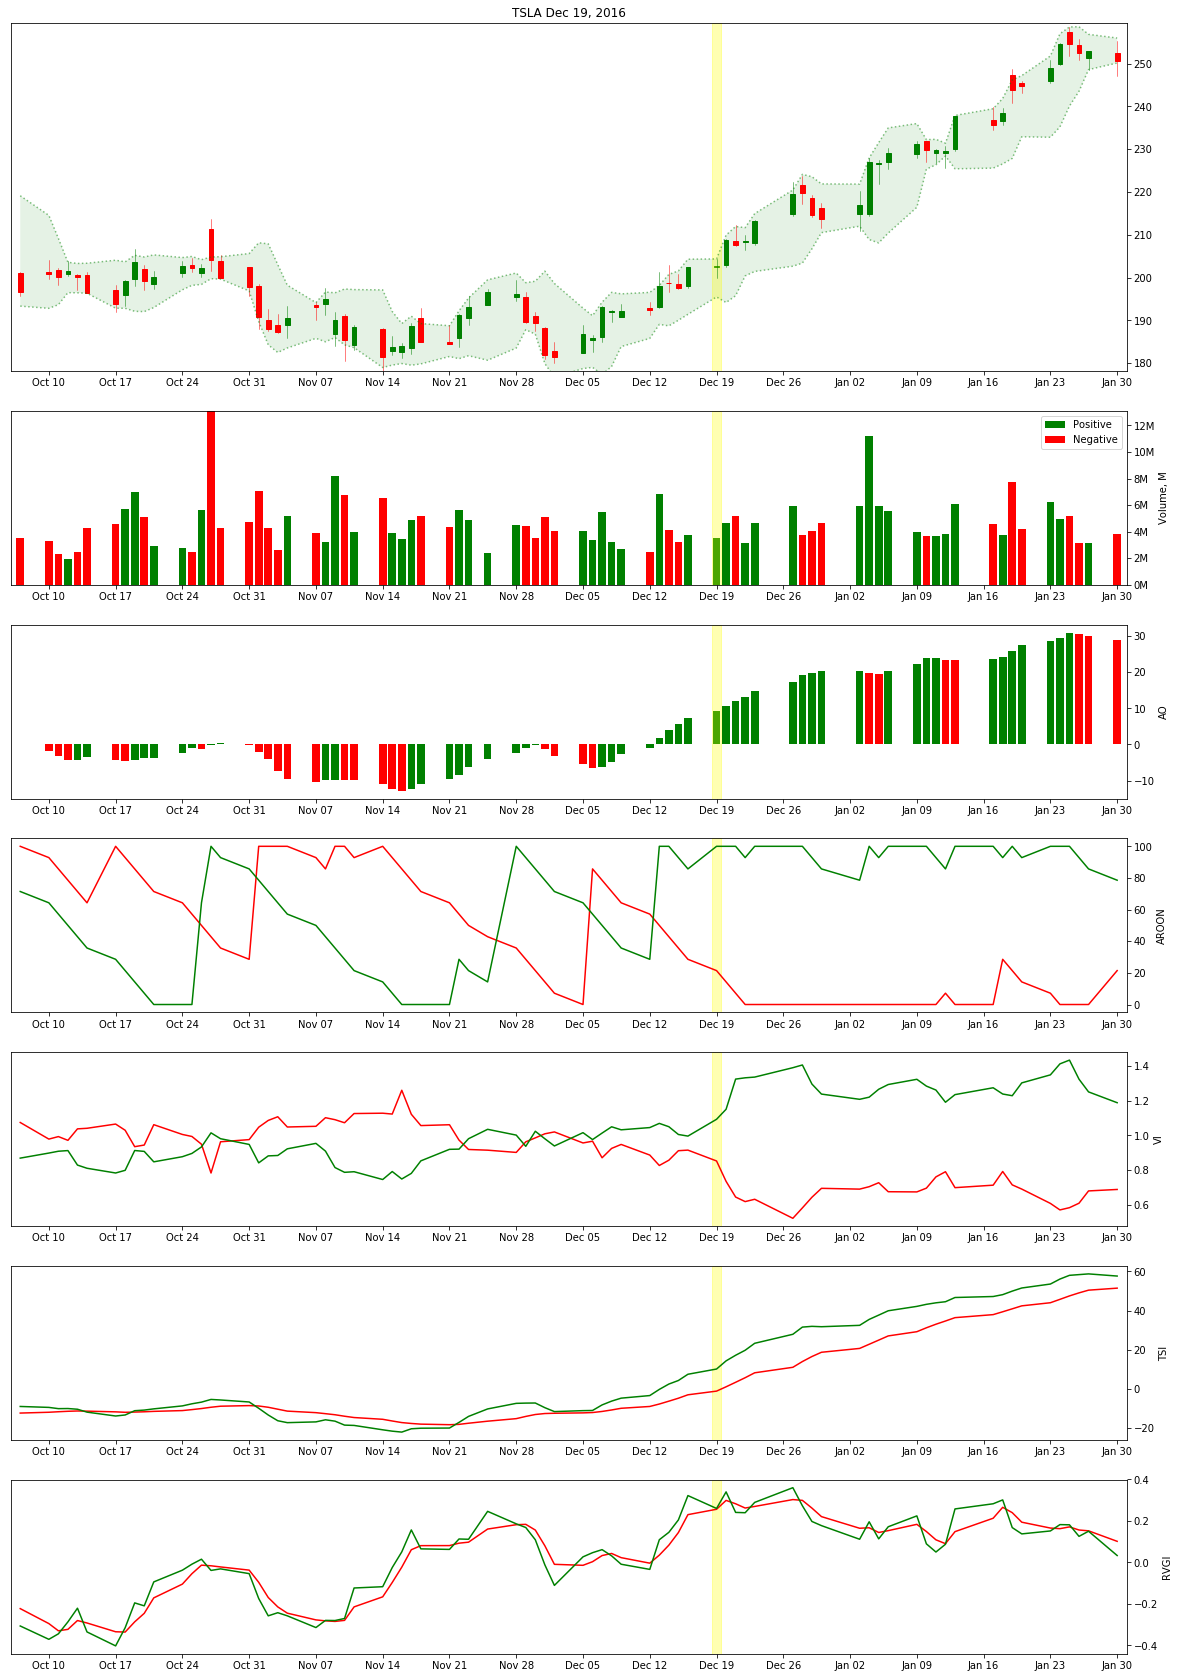

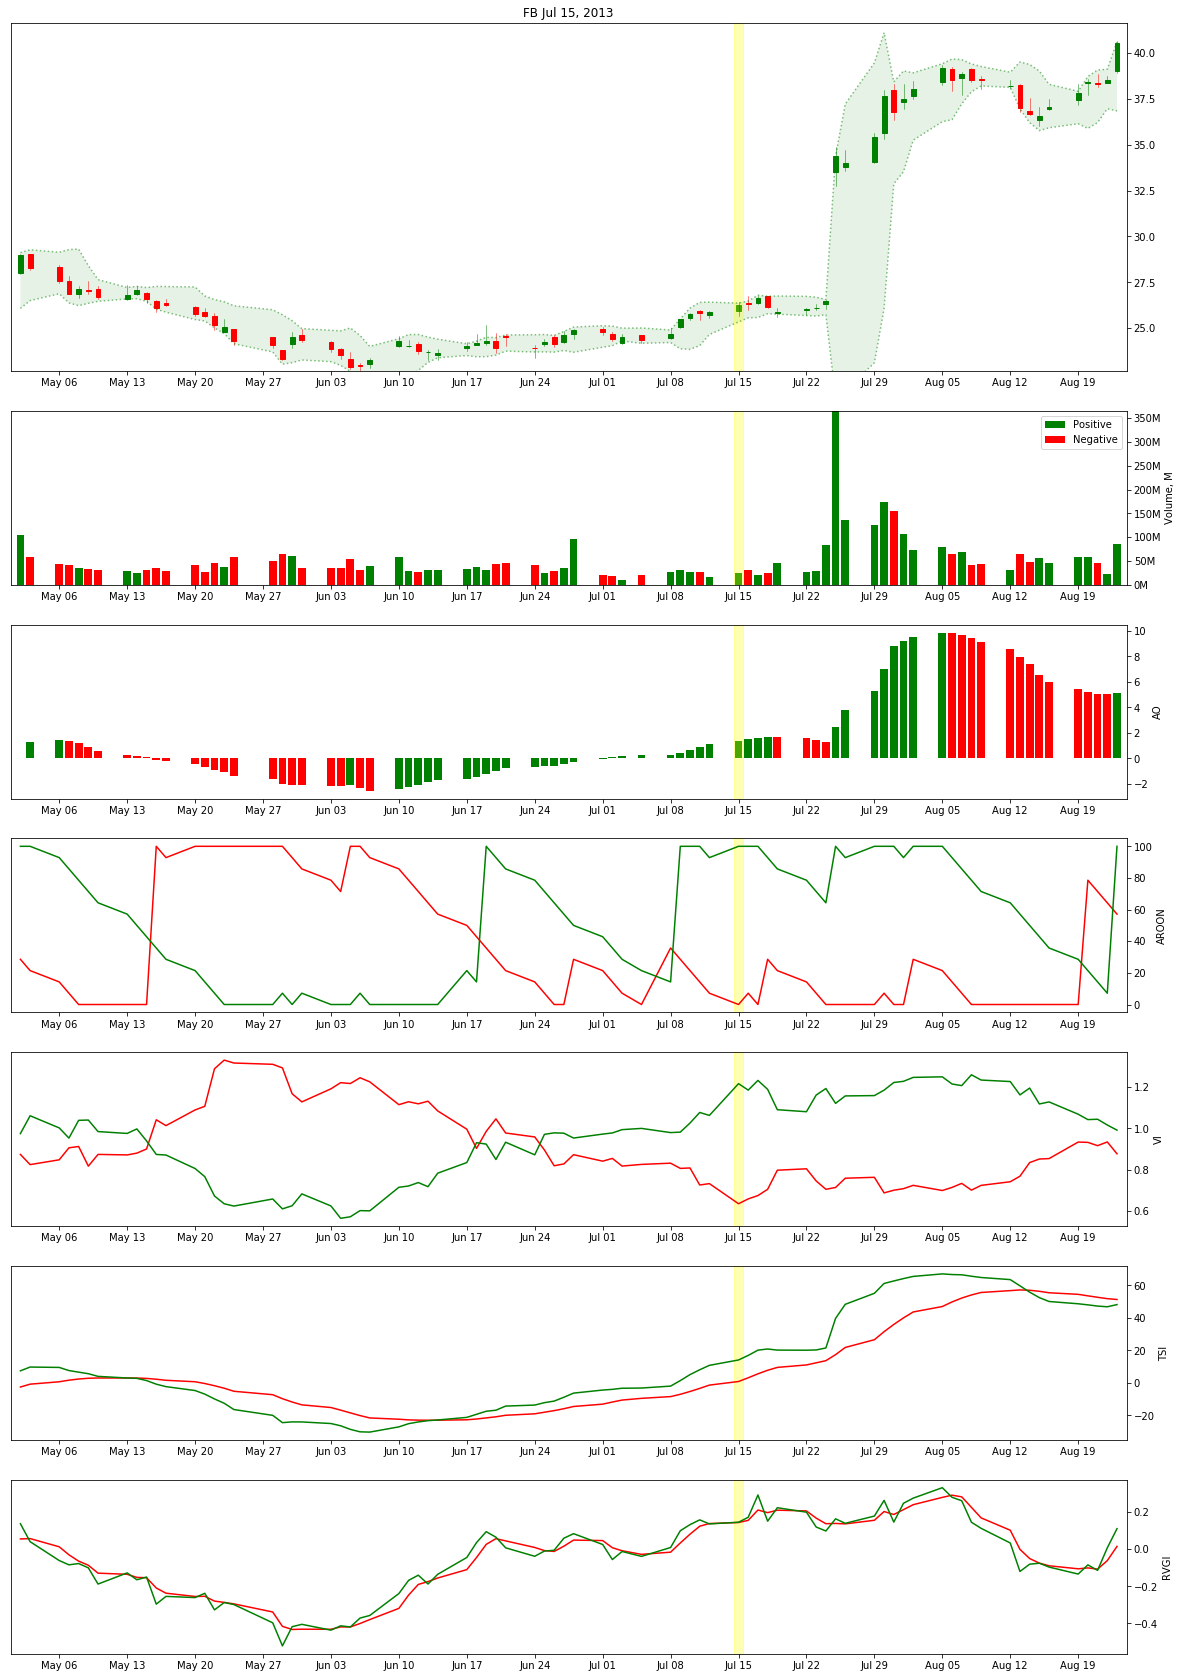

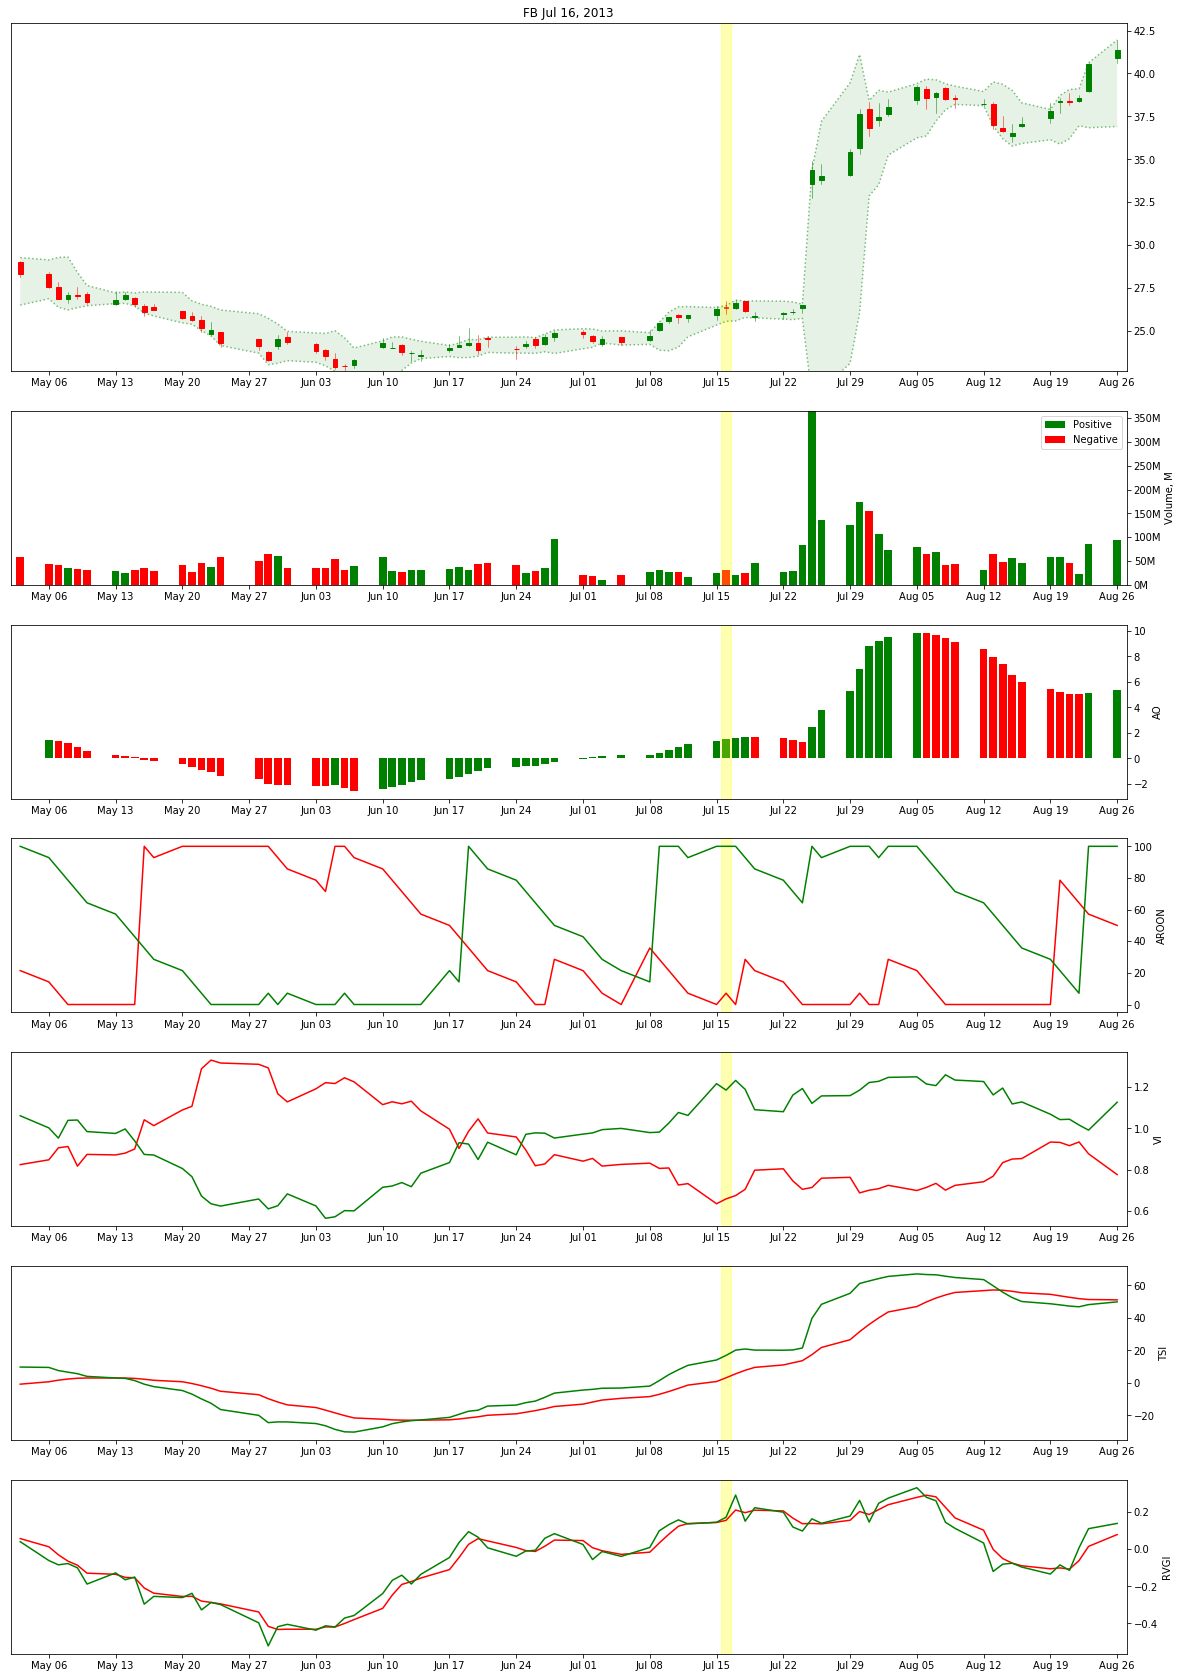

                   Return10days  Return20days  Return30days  Return60days
TSLA Sep 23, 2011      2.274452      3.866567     19.257013      6.482187
TSLA Mar 14, 2016      6.851037     15.965609     17.150830      8.668375
TSLA Dec 14, 2016     10.000501     15.758215     27.097486           NaN
TSLA Dec 19, 2016      5.929070     21.960245           NaN           NaN
FB Jul 15, 2013       29.642309     45.357686     55.631661     92.541846
FB Jul 16, 2013       35.448336     45.288762     54.559273     80.015204


In [6]:
stocks = ('TSLA', 'FB') # X, AAPL, TSLA, AMZN, FB, CLF, SHOP, SBUX, ILMN, NVDA, PCRX, VEEV, NFLX, DIS, BIIB
start, end = dt(2011, 1, 1), dt(2017, 1, 31)
return_days = (10, 20, 30, 60)
returns = pd.DataFrame(columns=["Return{}days".format(d) for d in return_days])
for stock in stocks:
    data = get_data(stock, start, end)
    key_instances = get_pattern_instances(data)    
    for instance in key_instances: 
        name = "{} {:%b %d, %Y}".format(stock, instance)
        plot_data(name, data, instance, show=False)        
        
        # (window.Close / first_day_open - 1) * 100
        # 10, 20, 30, 60 day returns
        instance_index = data.index.get_loc(instance)
        first_day_open = data.iloc[instance_index, 0]
        values = []
        for days in return_days:
            try:
                value = data.iloc[instance_index + days, 3]
            except IndexError:
                value = None
            else:
                value = (value / first_day_open - 1) * 100
            values.append(value)
        returns.loc[name] = values
        
plt.show()
print(returns)